# Fine-tuning a VLM for Structured Food Tag Extraction

Goal:
* Input: Food or not food image
* Output: Structured data for whether or not the image is food or not + food/ drink tags

## Resources
* Docs example of fine-tuning a VLM: https://ai.google.dev/gemma/docs/core/huggingface_vision_finetune_qlora?hl=tr
* Another doc example of inference with a VLM: https://github.com/google-gemini/gemma-cookbook/blob/main/Gemma/[Gemma_3n]Multimodal_understanding_with_HF.ipynb
* LoRa without regret https://huggingface.co/docs/trl/main/en/index
    * Thinking Machines blog: https://thinkingmachines.ai/blog/lora/
* Example of LoRA in the wild: https://developer.apple.com/apple-intelligence/foundation-models-adapter/

* PEFT (Parameter Efficient Fine-tuning) GitHub - https://github.com/huggingface/peft

* SmolVLM Docling paper - https://arxiv.org/pdf/2503.11576
  * Notes:
    * LLM alignment: To align the LLM part we freeze the vision encoder and train only the remaining network to adaph it to the new output format which it hasn't seen before.
    * Unfreeze vision encoder: After LLM alignment, unfreeze vision encoder and train the model on pretraining datasets (section 4.1) along with all task-specific conversion datasets inculuding tables, code, equations and charts
    * Workflow:
      * Stage 1 (frozen vision encoder): Freeze the vision encoder and teach the LLM part to output our desired structure (e.g. JSON for food/drink)
        * Note: Create a Trainer instance (STrainer) with one optimizer to get the state of the model and optimize it with a frozen vision backbone.
      * Stage 2 (unfrozen whole model): Unfreeze the vision encoder and teach the whole model to converge to your desired structure.


## Definitions

* PEFT = Parameter Efficient Fine-Tuning (only train a subset of the model parameters + hopefully still get good results)

* LORA = Low Rank Adaptation (LoRA = a form of PET)
    * You basically fine-tune an adapter model for your original model and optionally apply the adapter to the original model
    * Benefits of LoRA = you can train multiple adapters only and run different times depending on the required use case of your model

* QloRA = Quantized LoRA (fine-tune an adapter)
    * Train with quantized weights (even smaller than LoRA) for even more parameter efficient fine-tuning

In [1]:
!pip install -U bitsandbytes accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 47.0 MB/s eta 0:00:00


In [2]:
!pip install trl
!pip install num2words

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 530.9/530.9 kB 42.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.5/163.5 kB 17.5 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=e4c222c73f2bc834cea2108afec21ea0cde8f82c40a9809f3f6a6a13f52593bc
  Stored in directory: /root/.cache/pip/wheels/1a/bf/a1/4cee4f7678c68c5875ca89eaccf460593539805c3906722228
Successfully built docopt


In [3]:
import transformers
import torch
import trl

from peft import LoraConfig
from transformers import BitsAndBytesConfig

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


## Load Dataset

In [5]:
from datasets import load_dataset
from PIL import Image

dataset = load_dataset("berkeruveyik/vlm-food-4k-not-food-dataset")
dataset

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/263M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3698 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'category', 'output_json', 'output_yaml', 'image_name', 'image_id', 'food270_class_name', 'image_source', 'label'],
        num_rows: 3698
    })
})

In [6]:
example_sample =dataset['train'][330]
example_sample

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>,
 'category': 'beignets',
 'output_json': {'is_food': 1,
  'image_title': 'beignets',
  'food_items': ['sugar',
   'flour',
   'butter',
   'eggs',
   'milk',
   'cinnamon',
   'nutmeg',
   'vanilla extract'],
  'drink_items': []},
 'output_yaml': {'is_food': 1,
  'image_title': 'beignets',
  'food_items': ['sugar',
   'flour',
   'butter',
   'eggs',
   'milk',
   'cinnamon',
   'nutmeg',
   'vanilla extract'],
  'drink_items': []},
 'image_name': '26e72132134c47b0a9a3af5da2642ceb.jpg',
 'image_id': '26e72132134c47b0a9a3af5da2642ceb',
 'food270_class_name': 'beignets',
 'image_source': 'food270',
 'label': 1}

[INFO] Example output: {'is_food': 1, 'image_title': 'beignets', 'food_items': ['sugar', 'flour', 'butter', 'eggs', 'milk', 'cinnamon', 'nutmeg', 'vanilla extract'], 'drink_items': []}


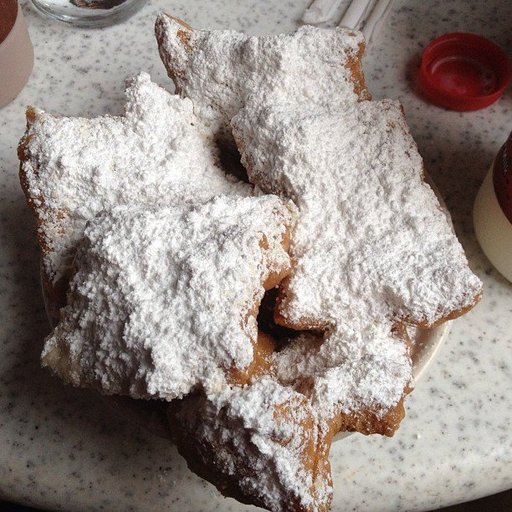

In [7]:
example_input = example_sample['image']
example_output = example_sample['output_json']

print(f'[INFO] Example output: {example_output}')
example_input

## format data for use with a VLM
* Input: image
* Output: structured json data with food tags

In [8]:
# system mesage
SYSTEM_MESSAGE = """ You are an expert food and drink image extractor.
You provide structured data to visual inputs classifying them as edible food/drink or not.
as well as titling the image with a simple simple food/drink related caption.
Finally you extract any and all visible food/drink items to lists.
"""

# user prompt with image input as well ass desired output
USER_PROMPT = """ Classify the give input image into food or not and if edible food or drink items are present, extract those to a list. If no food/drink items are visible, return emty list.

Only return valid JSON in the following form:

```json

{
    'is_food': 0, # int - 0 or 1 based on whether food/drinks are present (0 = no foods visible, 1 = foods visible)
    'image_title': '', # str - short food-related title for what foods/drinks are visible in the image, leave blank if no foods present
    'food_items' : [], # list[str] - list of visible edible food item nouns
    'drink_items': [] # list[str] - list of visible edible drink item nouns
}
```
"""

# create helper function to map our input/output sample to conversational format
def format_data(sample):
    return{
        'messages':[
            # Message 0 - [SYSTEM] System prompt (setting the scene)
            {
                'role': 'system',
                'content': [{'type':'text', 'text': SYSTEM_MESSAGE}]
            },
            # Message 1 - [USER] User input (image + prompt pair)
            {
                'role': 'user',
                'content': [
                    {
                        'type': 'image',
                        'image': sample['image']
                    },
                    {
                        'type': 'text',
                        'text': USER_PROMPT
                    },
                ]
            },
            # Message 2 - [MODEL] Ideal model output (structured json data)
            {
                'role': 'assistant',
                'content': [
                    {
                        'type': 'text',
                        'text': sample['output_json']
                    }
                ]
            },
        ]
    }

formatted_sample = format_data(example_sample)
formatted_sample

{'messages': [{'role': 'system',
   'content': [{'type': 'text',
     'text': ' You are an expert food and drink image extractor.\nYou provide structured data to visual inputs classifying them as edible food/drink or not.\nas well as titling the image with a simple simple food/drink related caption.\nFinally you extract any and all visible food/drink items to lists.\n'}]},
  {'role': 'user',
   'content': [{'type': 'image',
     'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>},
    {'type': 'text',
     'text': " Classify the give input image into food or not and if edible food or drink items are present, extract those to a list. If no food/drink items are visible, return emty list.\n\nOnly return valid JSON in the following form:\n\n```json\n\n{\n    'is_food': 0, # int - 0 or 1 based on whether food/drinks are present (0 = no foods visible, 1 = foods visible)\n    'image_title': '', # str - short food-related title for what foods/drinks are visible in the ima

In [9]:
# Format each item in the original dataset keeping the PIL image type
# Note: If we use •map(), image may get converted to bytes
dataset_processed = [format_data(sample) for sample in dataset["train"]]
dataset_processed[0]

{'messages': [{'role': 'system',
   'content': [{'type': 'text',
     'text': ' You are an expert food and drink image extractor.\nYou provide structured data to visual inputs classifying them as edible food/drink or not.\nas well as titling the image with a simple simple food/drink related caption.\nFinally you extract any and all visible food/drink items to lists.\n'}]},
  {'role': 'user',
   'content': [{'type': 'image',
     'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224>},
    {'type': 'text',
     'text': " Classify the give input image into food or not and if edible food or drink items are present, extract those to a list. If no food/drink items are visible, return emty list.\n\nOnly return valid JSON in the following form:\n\n```json\n\n{\n    'is_food': 0, # int - 0 or 1 based on whether food/drinks are present (0 = no foods visible, 1 = foods visible)\n    'image_title': '', # str - short food-related title for what foods/drinks are visible in the ima

In [10]:
# this took too long skipping for now
'''
dataset = dataset.map(format_data,
                      batched=False)

dataset["train"][0]

'''

'\ndataset = dataset.map(format_data,\n                      batched=False)\n\ndataset["train"][0]\n\n'

## Running a sample through a base model

Let's see how a non-fine-tuned model performs on our task.

To begin with we'll try out SmolVLM2-256M - https://huggingface.co/HuggingFaceTB/SmolVLM-256M-Instruct

In [11]:
example_base_model_input = dataset_processed[1576]['messages'][:2]  # only input messages (no output)
example_base_model_input

[{'role': 'system',
  'content': [{'type': 'text',
    'text': ' You are an expert food and drink image extractor.\nYou provide structured data to visual inputs classifying them as edible food/drink or not.\nas well as titling the image with a simple simple food/drink related caption.\nFinally you extract any and all visible food/drink items to lists.\n'}]},
 {'role': 'user',
  'content': [{'type': 'image',
    'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256>},
   {'type': 'text',
    'text': " Classify the give input image into food or not and if edible food or drink items are present, extract those to a list. If no food/drink items are visible, return emty list.\n\nOnly return valid JSON in the following form:\n\n```json\n\n{\n    'is_food': 0, # int - 0 or 1 based on whether food/drinks are present (0 = no foods visible, 1 = foods visible)\n    'image_title': '', # str - short food-related title for what foods/drinks are visible in the image, leave blank if n

In [12]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers import pipeline
from google.colab import userdata
import torch # Ensure torch is imported for torch.bfloat16

MODEL_ID = 'HuggingFaceTB/SmolVLM2-256M-Video-Instruct'

# Retrieve the Hugging Face token from Colab secrets
hf_token = userdata.get('HF_TOKEN')

pipe = pipeline(
    'image-text-to-text',
    model=MODEL_ID,
    device='cuda',
    dtype=torch.bfloat16, # Use torch_dtype explicitly for better consistency
    token=hf_token  # Pass the token explicitly
)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.03G [00:00<?, ?B/s]

Loading weights:   0%|          | 0/471 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/67.0 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/430 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/868 [00:00<?, ?B/s]

In [13]:
# Test the base model on an example input image
base_model_output = pipe(example_base_model_input,
                         max_new_tokens=256)

print(f"[INFO] Base model output:\n{base_model_output[0]['generated_text'][-1]['content']}")


Passing `generation_config` together with generation-related arguments=({'max_new_tokens'}) is deprecated and will be removed in future versions. Please pass either a `generation_config` object OR all generation parameters explicitly, but not both.
Both `max_new_tokens` (=256) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


[INFO] Base model output:
 The given image is a food or drink item.


In [14]:
print(f'[INFO] Ideal model output:\n')
dataset_processed[1576]['messages'][2]['content'][0]['text']

[INFO] Ideal model output:



{'is_food': 1,
 'image_title': 'lokma_dessert',
 'food_items': ['syrup', 'powdered sugar', 'red fruit topping', 'cake base'],
 'drink_items': []}

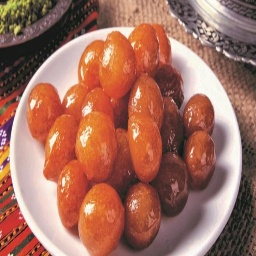

In [15]:
example_base_model_input[1]['content'][0]['image']

## Load the model without using pipline

`transformers. pipelin` allows simple loading and inference of the model.

But for more customization we'll want to load the model directly.|

In [16]:
# Load model in non-pipline way for more customization on the load
# Improve base model to be mode aligned with our ideal outputs

import torch
from transformers import BitsAndBytesConfig, AutoModelForImageTextToText,AutoProcessor


print(f'[INFO] using model {MODEL_ID}')

# define model init args
model_kwargs = dict(
    attn_implementation='eager',
    dtype=torch.bfloat16,
    device_map='auto'
)

# BitsAndBytesConfig int-4 config
# TK - Load the model in 4bit for smaller footprint? Not 100% sure on this...
# Note: If you are loading a quantized model, make sure the inputs are quantized as well,otherwise you will get errors.

#model_kwargs['quantization_config'] = BitsAndBytesConfig(
#    load_in_4bit=True,
#    bnb_4bit_use_double_quant=True,
#    bnb_4bit_quant_type="nf4",
#    bnb_4bit_compute_dtype=model_kwargs["dtype"],
#    bnb_4bit_quant_storage=model_kwargs["dtype"]
#    )

model = AutoModelForImageTextToText.from_pretrained(MODEL_ID,
                                                    **model_kwargs)
processor = AutoProcessor.from_pretrained(MODEL_ID)

[INFO] using model HuggingFaceTB/SmolVLM2-256M-Video-Instruct


Loading weights:   0%|          | 0/471 [00:00<?, ?it/s]

In [17]:
model

SmolVLMForConditionalGeneration(
  (model): SmolVLMModel(
    (vision_model): SmolVLMVisionTransformer(
      (embeddings): SmolVLMVisionEmbeddings(
        (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), padding=valid)
        (position_embedding): Embedding(1024, 768)
      )
      (encoder): SmolVLMEncoder(
        (layers): ModuleList(
          (0-11): 12 x SmolVLMEncoderLayer(
            (self_attn): SmolVLMVisionAttention(
              (k_proj): Linear(in_features=768, out_features=768, bias=True)
              (v_proj): Linear(in_features=768, out_features=768, bias=True)
              (q_proj): Linear(in_features=768, out_features=768, bias=True)
              (out_proj): Linear(in_features=768, out_features=768, bias=True)
            )
            (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
            (mlp): SmolVLMVisionMLP(
              (activation_fn): GELUTanh()
              (fc1): Linear(in_features=768, out_feature

In [18]:
#example_base_model_input_clone = example_base_model_input
#example_base_model_input_clone

In [19]:
#example_base_model_input_clone[1]['content'][0]['image'] = 'https://101limerick.com/wp-content/uploads/2025/08/Screenshot-2025-08-26-at-16.23.50.png'

In [20]:
#example_base_model_input_clone[1]

In [21]:
#example_base_model_input[1]

In [22]:
# Run the model on our example sample
example_chat_template_input = processor.apply_chat_template(
    [example_base_model_input[1]],
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors='pt'
).to(model.device, dtype=torch.bfloat16) # Move input to model's device and dtype, ensuring type consistency

# example_chat_template_input

input_len = example_chat_template_input["input_ids"].shape[-1]
print(f"[INFO] Input length: {input_len}")

with torch.inference_mode():
  generation_output_full = model.generate(**example_chat_template_input,
                                    max_new_tokens=256,
                                    do_sample=False)
  generation_output_short = generation_output_full[0][input_len:]

decoded_outputs = processor.decode(generation_output_short,
                                   skip_special_tokens=True)

print(decoded_outputs)

[INFO] Input length: 1315
 No food/drink items are present in the image.


## Train with QLoRA

In [23]:
default_config = LoraConfig()
for key, value in vars(default_config).items():
  print(f'{key}: {value}')

task_type: None
peft_type: PeftType.LORA
auto_mapping: None
peft_version: 0.18.1
base_model_name_or_path: None
revision: None
inference_mode: False
r: 8
target_modules: None
exclude_modules: None
lora_alpha: 8
lora_dropout: 0.0
fan_in_fan_out: False
bias: none
use_rslora: False
modules_to_save: None
init_lora_weights: True
layers_to_transform: None
layers_pattern: None
rank_pattern: {}
alpha_pattern: {}
megatron_config: None
megatron_core: megatron.core
trainable_token_indices: None
loftq_config: {}
eva_config: None
corda_config: None
use_dora: False
alora_invocation_tokens: None
use_qalora: False
qalora_group_size: 16
layer_replication: None
runtime_config: LoraRuntimeConfig(ephemeral_gpu_offload=False)
lora_bias: False
target_parameters: None
arrow_config: None
ensure_weight_tying: False
_custom_modules: None


### Setup QLoRA config

Docs on LoRA config: https://huggingface.co/docs/peft/en/package_reference/lora

In [24]:
# setup Lora config
from peft import LoraConfig

#peft_config = LoraConfig(
#    r=8,
#    lora_alpha=8,
#    lora_dropout=0.05,
#    bias='none',
#    target_modules='all-linear', # apply LoRA to all linear weight matrices
#    task_type='CAUSAL_LM',
#    modules_to_save=[
#        'lm_head',
#        'embed_tokens'
#        ]
#    )

from peft import LoraConfig, TaskType

peft_config = LoraConfig(
    r=16,                     # LoRA rank: lower = fewer trainable params, higher = more capacity
    lora_alpha=16,            # LoRA scaling factor: controls the strength of the adaptation
    lora_dropout=0.05,       # Dropout applied to LoRA layers during training
    bias="none",             # Whether to train bias parameters: "none", "all", or "lora_only"
    task_type='CAUSAL_LM',  # Task type hint used internally by PEFT

    # Module selection (these should not overlap in a conflicting way)
    target_modules="all-linear",   # Apply LoRA to all nn.Linear layers (auto-detected)

    # Exclude these modules from LoRA auto-detection (prevents overlap with modules_to_save)
    #exclude_modules=[
    #    "lm_head",            # Output projection head
    #    "embed_tokens",       # Input token embeddings
    #],

    # These modules will be fully fine-tuned (all weights trained and saved, not low-rank)
    modules_to_save=[
        "lm_head",            # Useful to fully train the output head for a new task
        "embed_tokens",       # Useful to adapt embeddings to domain/vocab shifts
    ],
)


#peft_config = LoraConfig(
#    r=16,                         # LoRA rank
#    lora_alpha=8,                # LoRA scaling
#    lora_dropout=0.1,            # Dropout on LoRA layers
#    task_type=TaskType.CAUSAL_LM,
#
#    # Apply adapters to these projection layers
#    target_modules=[
#        "q_proj",    # (common) query projection; replace if your model uses a different name
#        "gate_proj",
#        "up_proj",
#        "v_proj",
#    ],
#
#    use_dora=True,               # Enable DoRA (a LoRA variant)
#    init_lora_weights="gaussian" # Initialization for LoRA weights
#)



# Get our PEFT model

from peft import LoraConfig, get_peft_model

peft_model = get_peft_model(model,
                            peft_config)

# Print the number of trainable parameters
peft_model.print_trainable_parameters()

/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:1225: UserWarning: Model has `tie_word_embeddings=True` and a tied layer is part of the adapter, but `ensure_weight_tying` is not set to True. This can lead to complications, for example when merging the adapter or converting your model to formats other than safetensors. Check the discussion here: https://github.com/huggingface/peft/issues/2777
  warnings.warn(msg)


trainable params: 64,515,072 || all params: 321,000,000 || trainable%: 20.0982


### Setup SFTConfig

In [25]:
from trl import SFTConfig

training_args = SFTConfig(
    output_dir="smolvlm2-256m-FoodExtract-Vision-v1",
    num_train_epochs=1,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,
    gradient_checkpointing=True,
    optim="adamw_torch_fused",
    logging_steps=25,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-4,
    bf16=True,
    save_total_limit=1,
    max_grad_norm=1.0,
    warmup_ratio=0.03,
    lr_scheduler_type="constant",
    push_to_hub=True,
    report_to="none",
    gradient_checkpointing_kwargs={
        "use_reentrant": False
    },
    dataset_text_field="",
    dataset_kwargs={"skip_prepare_dataset": True},
    load_best_model_at_end=True,
)

training_args.remove_unused_columns = False  # important for collator


warmup_ratio is deprecated and will be removed in v5.2. Use `warmup_steps` instead.


Next we'll create a data collator to encode text and image pairs into batches.

We'll also create a helper function called 'process_vision_info to stack vision tensors.

In [26]:
def process_vision_info(messages: list[dict]) -> list[Image.Image]:
    image_inputs = []
    # Iterate through each conversation
    for msg in messages:
        # Get content (ensure it's a list)
        content = msg.get("content", [])
        if not isinstance(content, list):
            content = [content]

        # Check each content element for images
        for element in content:
            if isinstance(element, dict) and (
                "image" in element or element.get("type") == "image"
            ):
                # Get the image and convert to RGB
                if "image" in element:
                    image = element["image"]
                else:
                    image = element
                image_inputs.append(image.convert("RGB"))
    return image_inputs


In [27]:
processor.tokenizer.pad_token_id

2

In [28]:
processor.tokenizer. convert_ids_to_tokens (262144)

In [29]:
# collate_fn fonksiyonunu hatayı düzelterek burada yeniden tanımlıyoruz
def collate_fn(examples):
    texts = []
    images = []

    for example in examples:
        image_inputs = process_vision_info(example["messages"])
        text = processor.apply_chat_template(
            example["messages"], add_generation_prompt=False, tokenize=False
        )

        texts.append(text.strip())
        images.append(image_inputs)

    # Tokenize the texts and process the images
    batch_input = processor(
        text=texts,
        images=images,
        return_tensors="pt",
        padding=True
    )

    labels = batch_input["input_ids"].clone()

    # HATA DÜZELTME: convert_tokens_to_ids kullanıyoruz
    image_token_id = processor.tokenizer.convert_tokens_to_ids("<image>")

    # Mask tokens for not being used in the loss computation
    labels[labels == processor.tokenizer.pad_token_id] = -100
    labels[labels == image_token_id] = -100

    batch_input["labels"] = labels
    return batch_input

In [30]:
import random
random.seed(42)

dataset_shuffled = random.sample(dataset_processed, k=len(dataset_processed))

train_split = round(0.8 * len(dataset_processed))

train_dataset = dataset_shuffled[:train_split]
val_dataset = dataset_shuffled[train_split:]

print(f" [INFO] Number of total samples: {len(dataset_processed)}")
print(f" [INFO] Number of train samples: {len(train_dataset)}")
print (f" [INFO] Number of eval samples: {len(val_dataset)}")

 [INFO] Number of total samples: 3698
 [INFO] Number of train samples: 2958
 [INFO] Number of eval samples: 740


In [31]:
random.choice(train_dataset)

{'messages': [{'role': 'system',
   'content': [{'type': 'text',
     'text': ' You are an expert food and drink image extractor.\nYou provide structured data to visual inputs classifying them as edible food/drink or not.\nas well as titling the image with a simple simple food/drink related caption.\nFinally you extract any and all visible food/drink items to lists.\n'}]},
  {'role': 'user',
   'content': [{'type': 'image',
     'image': <PIL.Image.Image image mode=RGB size=308x512>},
    {'type': 'text',
     'text': " Classify the give input image into food or not and if edible food or drink items are present, extract those to a list. If no food/drink items are visible, return emty list.\n\nOnly return valid JSON in the following form:\n\n```json\n\n{\n    'is_food': 0, # int - 0 or 1 based on whether food/drinks are present (0 = no foods visible, 1 = foods visible)\n    'image_title': '', # str - short food-related title for what foods/drinks are visible in the image, leave blank if

In [32]:
train_dataset[0], val_dataset[0]

({'messages': [{'role': 'system',
    'content': [{'type': 'text',
      'text': ' You are an expert food and drink image extractor.\nYou provide structured data to visual inputs classifying them as edible food/drink or not.\nas well as titling the image with a simple simple food/drink related caption.\nFinally you extract any and all visible food/drink items to lists.\n'}]},
   {'role': 'user',
    'content': [{'type': 'image',
      'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>},
     {'type': 'text',
      'text': " Classify the give input image into food or not and if edible food or drink items are present, extract those to a list. If no food/drink items are visible, return emty list.\n\nOnly return valid JSON in the following form:\n\n```json\n\n{\n    'is_food': 0, # int - 0 or 1 based on whether food/drinks are present (0 = no foods visible, 1 = foods visible)\n    'image_title': '', # str - short food-related title for what foods/drinks are visible in

### Train the model with loRA

In [33]:
# freeze the vision bavkbone and only train the LLM parts
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    frozen = total - trainable
    return total, trainable, frozen

# Before freezing
total, trainable, frozen = count_parameters(model)
print("Before freezing:")
print(f"  Total: {total:,}")
print(f"  Trainable: {trainable:,}")
print(f"  Frozen: {frozen:,}")

# Freeze vision model
for param in model.model.vision_model.parameters():
    param.requires_grad = False

# After freezing
total, trainable, frozen = count_parameters(model)
print("\nAfter freezing vision_model:")
print(f"  Total: {total:,}")
print(f"  Trainable: {trainable:,}")
print(f"  Frozen: {frozen:,}")


Before freezing:
  Total: 321,000,000
  Trainable: 64,515,072
  Frozen: 256,484,928

After freezing vision_model:
  Total: 321,000,000
  Trainable: 61,860,864
  Frozen: 259,139,136


In [34]:
from trl import SFTTrainer

trainer = SFTTrainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    #peft_config=peft_config, # Note: if the model is already PEFT-ified, don't need to re-pass the PEFT config ()
    processing_class=processor,
    data_collator=collate_fn
)

trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 49279, 'bos_token_id': 1, 'pad_token_id': 2}.


Epoch,Training Loss,Validation Loss
1,0.054298,0.051587


TrainOutput(global_step=185, training_loss=0.373287059165336, metrics={'train_runtime': 3217.141, 'train_samples_per_second': 0.919, 'train_steps_per_second': 0.058, 'total_flos': 6633560275305984.0, 'train_loss': 0.373287059165336})

In [35]:
# Let's check which checkpoint is the best model
if 'trainer' in globals():
  best_checkpoint = trainer.state.best_model_checkpoint
  best_metric = trainer.state.best_metric
  print(f"[INFO] Best Checkpoint Path: {best_checkpoint}")
  print(f"[INFO] Best Validation Loss Value: {best_metric}")

  print("\nNote: 'loaded_model' is currently using the weights of this checkpoint (because save_model() saves the best one).")
else:
  print("[WARNING] Variable 'trainer' not found. Was the training cell executed?")

[INFO] Best Checkpoint Path: smolvlm2-256m-FoodExtract-Vision-v1/checkpoint-185
[INFO] Best Validation Loss Value: 0.051586903631687164

Note: 'loaded_model' is currently using the weights of this checkpoint (because save_model() saves the best one).


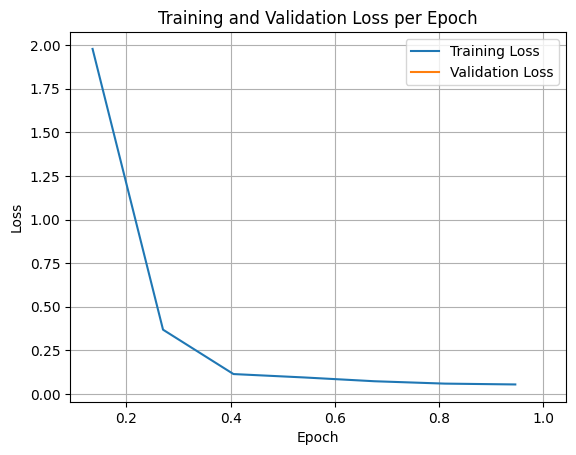

In [36]:
import matplotlib.pyplot as plt

# Access the log history
log_history = trainer.state.log_history

# Extract training / validation loss
train_losses = [log["loss"] for log in log_history if "loss" in log]
epoch_train = [log["epoch"] for log in log_history if "loss" in log]
eval_losses = [log["eval_loss"] for log in log_history if "eval_loss" in log]
epoch_eval = [log["epoch"] for log in log_history if "eval_loss" in log]

# Plot the training loss
plt.plot(epoch_train, train_losses, label="Training Loss")
plt.plot(epoch_eval, eval_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss per Epoch")
plt.legend()
plt.grid(True)
plt.show()

In [37]:
trainer.save_model()

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...sion-v1/training_args.bin: 100%|##########| 5.71kB / 5.71kB            

  ...adapter_model.safetensors:  29%|##8       | 41.8MB /  145MB            

No files have been modified since last commit. Skipping to prevent empty commit.


## Test the trained model

In [38]:
del model
del trainer
torch.cuda.empty_cache()

In [39]:
CHECKPOINT_DIR_NAME = '/content/smolvlm2-256m-FoodExtract-Vision-v1/checkpoint-185' #args.output_dir
CHECKPOINT_DIR_NAME

'/content/smolvlm2-256m-FoodExtract-Vision-v1/checkpoint-185'

In [40]:
# upload original model
from transformers import pipeline

pt_pipe = pipeline(
    'image-text-to-text',
    model=MODEL_ID,
    device='cuda',
    dtype=torch.bfloat16
)

# do_sample = False for deterministic responses
pt_pipe.model.generation_config.do_sample = False
pt_pipe.model.generation_config.pad_token_id = processor.tokenizer.eos_token_id

Loading weights:   0%|          | 0/471 [00:00<?, ?it/s]

In [41]:
# upload fine-tuned model
ft_pipe = pipeline(
    'image-text-to-text',
    model=CHECKPOINT_DIR_NAME,
    device='cuda',
    dtype=torch.bfloat16
)

# do_sample = False for deterministic responses
ft_pipe.model.generation_config.do_sample = False
ft_pipe.model.generation_config.pad_token_id = processor.tokenizer.eos_token_id

Loading weights:   0%|          | 0/471 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:1225: UserWarning: Model has `tie_word_embeddings=True` and a tied layer is part of the adapter, but `ensure_weight_tying` is not set to True. This can lead to complications, for example when merging the adapter or converting your model to formats other than safetensors. Check the discussion here: https://github.com/huggingface/peft/issues/2777
  warnings.warn(msg)


Loading weights:   0%|          | 0/566 [00:00<?, ?it/s]

SmolVLMForConditionalGeneration LOAD REPORT from: /content/smolvlm2-256m-FoodExtract-Vision-v1/checkpoint-185
Key                                                          | Status     | 
-------------------------------------------------------------+------------+-
base_model.model.lm_head.weight                              | UNEXPECTED | 
model.text_model.embed_tokens.weight                         | UNEXPECTED | 
model.text_model.embed_tokens.modules_to_save.default.weight | MISSING    | 
lm_head.modules_to_save.default.weight                       | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


In [42]:
pt_pipe.device, ft_pipe.device

(device(type='cuda'), device(type='cuda'))

[INFO] Random sample model input:
{'role': 'user', 'content': [{'type': 'image', 'image': <PIL.Image.Image image mode=RGB size=1200x757 at 0x7F3044247890>}, {'type': 'text', 'text': " Classify the give input image into food or not and if edible food or drink items are present, extract those to a list. If no food/drink items are visible, return emty list.\n\nOnly return valid JSON in the following form:\n\n```json\n\n{\n    'is_food': 0, # int - 0 or 1 based on whether food/drinks are present (0 = no foods visible, 1 = foods visible)\n    'image_title': '', # str - short food-related title for what foods/drinks are visible in the image, leave blank if no foods present\n    'food_items' : [], #\xa0list[str] - list of visible edible food item nouns\n    'drink_items': [] #\xa0list[str] - list of visible edible drink item nouns\n}\n```\n"}]}

[INFO] Random sample model output:
{'role': 'assistant', 'content': [{'type': 'text', 'text': {'is_food': 1, 'image_title': 'radish', 'food_items': [

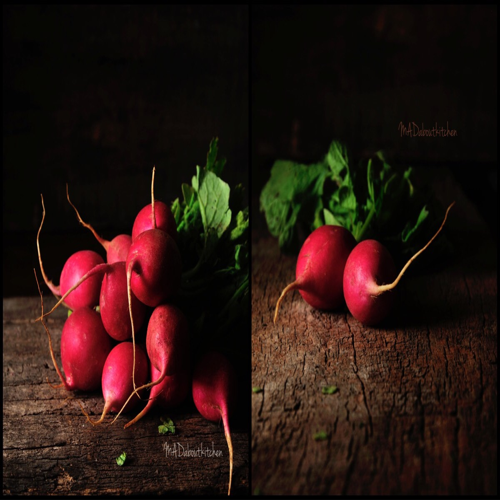

In [78]:
random_val_sample = random.choice(val_dataset)
random_val_sample_model_input = random_val_sample['messages'][1]
random_val_sample_model_output = random_val_sample['messages'][-1]
random_val_sample_image = random_val_sample_model_input['content'][0]['image']

print(f'[INFO] Random sample model input:\n{random_val_sample_model_input}')
print()
print(f'[INFO] Random sample model output:\n{random_val_sample_model_output}')

random_val_sample_image.resize((500,500))


In [79]:
pt_pipe_output = pt_pipe(text=[random_val_sample_model_input],
                        max_new_tokens=256)
pt_pipe_output_text = pt_pipe_output [0] ["generated_text"][-1] ["content"]
print (f" [INFO] Generated output text from pre-trained model: \n{pt_pipe_output_text}")

ft_pipe_output = ft_pipe(text=[random_val_sample_model_input], max_new_tokens=256)
ft_pipe_output_text = ft_pipe_output [0] ["generated_text"][-1] ["content"]
print(f"[INFO] Generated output text from fine-tuned model: \n{ft_pipe_output_text}")

Both `max_new_tokens` (=256) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


 [INFO] Generated output text from pre-trained model: 
 No food/drink items are present in the image.


Both `max_new_tokens` (=256) and `max_length`(=20) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


[INFO] Generated output text from fine-tuned model: 
 {'is_food': 1, 'image_title': 'pumpkin', 'food_items': ['pumpkin seeds', 'pumpkin'], 'drink_items': []}


### Test the custom image

In [ ]:
image_path ='/content/IMG_3808.JPG'
image = Image.open(image_path)
image =image.resize((500,500))
image

In [ ]:
random_val_sample_model_input

In [ ]:
def format_sample_to_message(input_image):
  return{'role': 'user',
 'content': [{'type': 'image',
   'image': input_image},
  {'type': 'text',
   'text': " Classify the give input image into food or not and if edible food or drink items are present, extract those to a list. If no food/drink items are visible, return emty list.\n\nOnly return valid JSON in the following form:\n\n```json\n\n{\n    'is_food': 0, # int - 0 or 1 based on whether food/drinks are present (0 = no foods visible, 1 = foods visible)\n    'image_title': '', # str - short food-related title for what foods/drinks are visible in the image, leave blank if no foods present\n    'food_items' : [], #\xa0list[str] - list of visible edible food item nouns\n    'drink_items': [] #\xa0list[str] - list of visible edible drink item nouns\n}\n```\n"}]}

In [ ]:
test_input_sample = format_sample_to_message(image)
test_input_sample

In [ ]:
# Run the model on our example sample
val_chat_template_input = processor.apply_chat_template(
    [test_input_sample],
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors='pt'
).to(device)#DEVICE # Move input to model's device and dtype, ensuring type consistency

# example_chat_template_input

input_len = val_chat_template_input["input_ids"].shape[-1]
print(f"[INFO] Input length: {input_len}")

with torch.inference_mode():
  val_generation_output_full = loaded_model.generate(**val_chat_template_input,
                                    max_new_tokens=256,
                                    do_sample=False)
  val_generation_output_short = val_generation_output_full[0][input_len:]

val_decoded_outputs = processor.decode(val_generation_output_short,
                                   skip_special_tokens=True)

print(val_decoded_outputs)

In [ ]:
print(f"[INFO] Model outputs: {val_decoded_outputs}")
image.resize(size=(500, 500))

## Uploading the model to the Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import shutil
import os
from google.colab import drive


if not os.path.exists('/content/drive'):
    drive.mount('/content/drive')


source_dir = args.output_dir
destination_dir = "/content/drive/MyDrive/ColabNotebooks/vlm_finetune/gemma-3n-FoodExtract-Vision-v1"

print(f"[INFO] Model kopyalanıyor...\nKaynak: {source_dir}\nHedef:  {destination_dir}")


try:

    shutil.copytree(source_dir, destination_dir, dirs_exist_ok=True)
    print(f"\n[BAŞARILI] Model Google Drive'a başarıyla kaydedildi! ✅")
    print(f"Konum: {destination_dir}")
except Exception as e:
    print(f"\n[HATA] Kayıt sırasında bir sorun oluştu: {e} ❌")

### Notes

* **Datatypes:** Make sure model inputs are the same dtype as the model loaded (e.g. if model is quantized, inputs should be quanized too or if model is bfloat16, inputs should be bfloat16 as well)

* **Prompt inputs:** If not using `transformers.pipeline` beware that the system_prompt may have to be folded into the user_prompt, otherwise there will be errors.